In [72]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader

In [73]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [92]:
# 1. Load dataset
import zipfile

DATA_PATH = "/content/drive/MyDrive/datasets/dataverse_files.zip"

# Open the zip file
with zipfile.ZipFile(DATA_PATH, 'r') as zip_ref:
    all_files = zip_ref.namelist()

In [93]:
# Lấy danh sách các ID bệnh nhân
patient_ids = list(set([f.split("_")[0] for f in all_files if f.endswith("_8min_signal.csv")]))
print(f"📌 Số lượng bệnh nhân: {len(patient_ids)}")


📌 Số lượng bệnh nhân: 42


In [96]:
# 2. Load và tiền xử lý dữ liệu
X_all, Y_all = [], []

with zipfile.ZipFile(DATA_PATH, 'r') as zip_ref:
    for patient_id in patient_ids:
        try:
            # Đọc dữ liệu từ file ZIP
            with zip_ref.open(f"{patient_id}_8min_signal.csv") as signal_file:
                signal_df = pd.read_csv(signal_file)
            with zip_ref.open(f"{patient_id}_8min_param.csv") as param_file:
                param_df = pd.read_csv(param_file)

            fs = param_df["samplingrate_pleth"].values[0]  # Tần số lấy mẫu (300 Hz)

            # Chuẩn hóa tín hiệu
            signal_df["pleth_norm"] = (signal_df["pleth_y"] - signal_df["pleth_y"].min()) / \
                                      (signal_df["pleth_y"].max() - signal_df["pleth_y"].min()) * 2 - 1

            signal_df["co2_norm"] = (signal_df["co2_y"] - signal_df["co2_y"].min()) / \
                                    (signal_df["co2_y"].max() - signal_df["co2_y"].min())

            # Chia thành cửa sổ 9.6s
            window_size = int(9.6 * fs)  # 2880 mẫu
            stride = int(1 * fs)  # 1 giây

            for i in range(0, len(signal_df) - window_size, stride):
                X_all.append(signal_df["pleth_norm"].values[i:i + window_size])
                Y_all.append(signal_df["co2_norm"].values[i:i + window_size])

            print(f"✅ Xử lý xong bệnh nhân {patient_id}")
        except Exception as e:
            print(f"⚠️ Lỗi khi xử lý bệnh nhân {patient_id}: {e}")


✅ Xử lý xong bệnh nhân csv/0128
✅ Xử lý xong bệnh nhân csv/0331
✅ Xử lý xong bệnh nhân csv/0009
✅ Xử lý xong bệnh nhân csv/0030
✅ Xử lý xong bệnh nhân csv/0122
✅ Xử lý xong bệnh nhân csv/0330
✅ Xử lý xong bệnh nhân csv/0031
✅ Xử lý xong bệnh nhân csv/0104
✅ Xử lý xong bệnh nhân csv/0035
✅ Xử lý xong bệnh nhân csv/0142
✅ Xử lý xong bệnh nhân csv/0332
✅ Xử lý xong bệnh nhân csv/0147
✅ Xử lý xong bệnh nhân csv/0029
✅ Xử lý xong bệnh nhân csv/0311
✅ Xử lý xong bệnh nhân csv/0032
✅ Xử lý xong bệnh nhân csv/0370
✅ Xử lý xong bệnh nhân csv/0329
✅ Xử lý xong bệnh nhân csv/0133
✅ Xử lý xong bệnh nhân csv/0322
✅ Xử lý xong bệnh nhân csv/0134
✅ Xử lý xong bệnh nhân csv/0028
✅ Xử lý xong bệnh nhân csv/0127
✅ Xử lý xong bệnh nhân csv/0103
✅ Xử lý xong bệnh nhân csv/0016
✅ Xử lý xong bệnh nhân csv/0121
✅ Xử lý xong bệnh nhân csv/0312
✅ Xử lý xong bệnh nhân csv/0105
✅ Xử lý xong bệnh nhân csv/0115
✅ Xử lý xong bệnh nhân csv/0038
✅ Xử lý xong bệnh nhân csv/0328
✅ Xử lý xong bệnh nhân csv/0125
✅ Xử lý 

In [97]:
# Chuyển thành NumPy arrays
X_all = np.array(X_all)
Y_all = np.array(Y_all)
print(f"📌 Dữ liệu huấn luyện: X.shape = {X_all.shape}, Y.shape = {Y_all.shape}")

📌 Dữ liệu huấn luyện: X.shape = (19782, 2880), Y.shape = (19782, 2880)


In [98]:
# Chia dữ liệu thành train/test
X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=0.2, random_state=42)

In [99]:
# 6. Dataset class
class RespiratoryDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
        self.Y = torch.tensor(Y, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

train_dataset = RespiratoryDataset(X_train, Y_train)
test_dataset = RespiratoryDataset(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [100]:
# 5. Định nghĩa mô hình CNN Encoder-Decoder
class CorrEncoder(nn.Module):
    def __init__(self):
        super(CorrEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 8, kernel_size=150, stride=1, padding=20),
            nn.ReLU(),
            nn.Conv1d(8, 8, kernel_size=75, stride=1, padding=10),
            nn.ReLU(),
            nn.Conv1d(8, 8, kernel_size=50, stride=1, padding=10),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(8, 8, kernel_size=50, stride=1, padding=10),
            nn.ReLU(),
            nn.ConvTranspose1d(8, 8, kernel_size=75, stride=1, padding=10),
            nn.ReLU(),
            nn.ConvTranspose1d(8, 1, kernel_size=150, stride=1, padding=20),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [101]:
# 6. Khởi tạo mô hình, loss function và optimizer
model = CorrEncoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)


In [102]:
# 7. Huấn luyện mô hình
num_epochs = 2
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        X_batch, Y_batch = batch
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, Y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}")

Epoch 1/2, Loss: 0.1510
Epoch 2/2, Loss: 0.1404


In [103]:
# 8. Đánh giá mô hình
model.eval()
test_loss = 0
with torch.no_grad():
    for batch in test_loader:
        X_batch, Y_batch = batch
        output = model(X_batch)
        loss = criterion(output, Y_batch)
        test_loss += loss.item()

print(f"Test Loss: {test_loss/len(test_loader):.4f}")


Test Loss: 0.1373


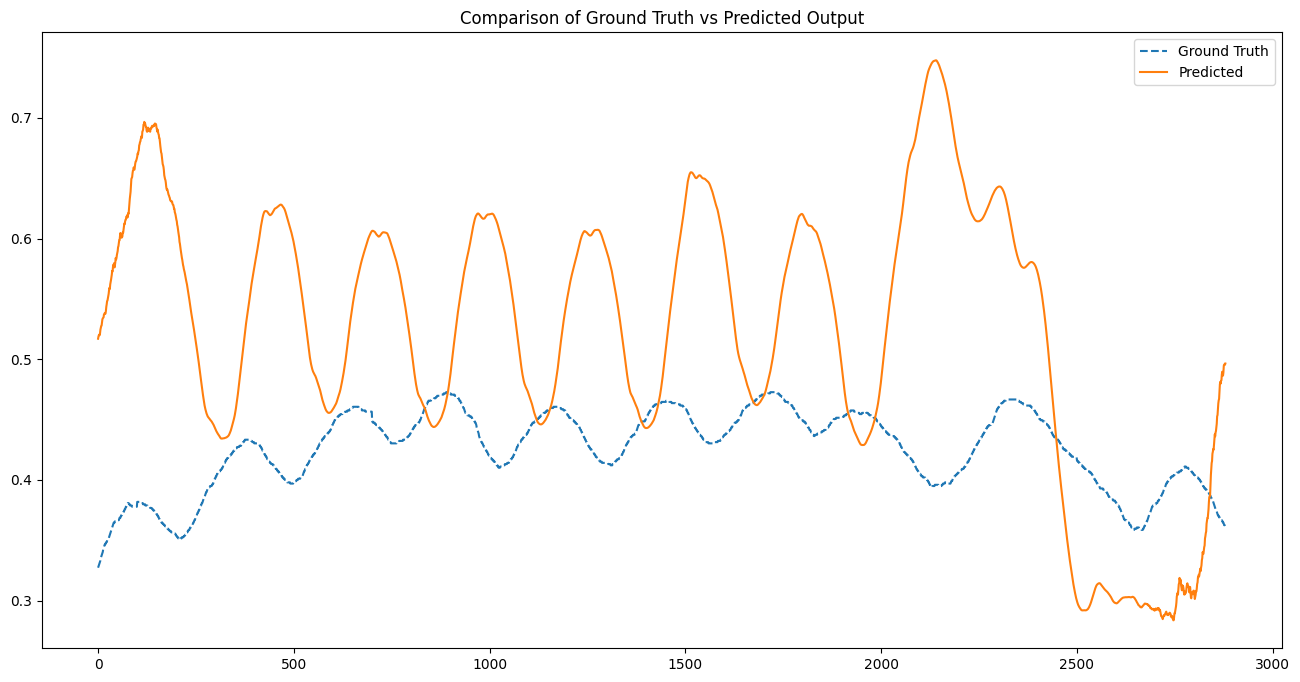

In [104]:
# 9. Trực quan hóa kết quả
sample_idx = np.random.randint(len(test_dataset))
X_sample, Y_sample = test_dataset[sample_idx]
X_sample = X_sample.unsqueeze(0)  # Thêm batch dimension

with torch.no_grad():
    Y_pred = model(X_sample)

plt.figure(figsize=(16, 8))
plt.plot(Y_sample.squeeze().numpy(), label="Ground Truth", linestyle="dashed")
plt.plot(Y_pred.squeeze().numpy(), label="Predicted")
plt.legend()
plt.title("Comparison of Ground Truth vs Predicted Output")
plt.show()